# Task 1
This implementation of image recoloring using a CNN was based on [this notebook](https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb) that was recommended on the task's description.

 ### Setup
 We start by importing all libraries that we might need such as torch and tourchvision to import, load and process data, skimage,PIL, etc.

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from skimage import color
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# from PIL import Image
from torchsummary import summary
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Let's also select the best available device (gpu or cpu) and define some inicial parameters for training

In [34]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
num_epochs = 50
batch_size = 512
learning_rate = 1e-3
num_workers = 2 # how many processes are used to load the data

Using cuda device


### Data Loading
As sugested both in the task description and the reference notebook we are going to use the CIFAR-10 dataset for simplicity and to then continue with the same data for task 2.

It is a standard import using torch and we only need to convert the image from the rgb color space to Lab. This new color space has a Lightness channel __L__ we will be feeding as input and 2 Hue channels __a__ and __b__ (from green to magenta, and from blue to yellow respectively) that we want the network to predict.

In [7]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
data_aug = transforms.Compose([
    transforms.Lambda(import_image)
  ])

training_data = datasets.CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


We will define a covolutional neural network and train it to predict the hue value of the black and white images.
It is composed of layers of convolution and reverse convolution intercalated by batch normalization. For the output we will be returning the final hue values as well as the result of one of the middle layers, this so that we can later use these parameters in the classifier of task 2 instead of just passing the predicted hue value, and, hopefully, give the classifier more complex feature data.

In [35]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        intermediateFeatures = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(intermediateFeatures)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x, intermediateFeatures

cnet = ColorNet()
cnet = cnet.to(device)



num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


We can take a look at its shape bellow

In [30]:
summary(cnet,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
            Conv2d-9            [-1, 128, 4, 4]         147,584
      BatchNorm2d-10            [-1, 128, 4, 4]             256
           Conv2d-11            [-1, 128, 4, 4]         147,584
      BatchNorm2d-12            [-1, 128, 4, 4]             256
  ConvTranspose2d-13             [-1, 64, 8, 8]         131,136
      BatchNorm2d-14             [-1, 6

### Training
The Adam optimizier and mean square error loss functions are used in training as they are indicated for colourization tasks and work well in a range of other tasks.
As said before we will be inputing just the L channel of the image and calculating the loss by comparing the ground truth of a and b channels to the predicted values and propagating the apropriate gradient backwards. This is repeated for a specified number of epochs. 

In [36]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch,_ = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))



Training ...
Epoch [1 / 50] average reconstruction error: 173.081652
Epoch [2 / 50] average reconstruction error: 154.453904
Epoch [3 / 50] average reconstruction error: 148.853844
Epoch [4 / 50] average reconstruction error: 145.205518
Epoch [5 / 50] average reconstruction error: 141.372249
Epoch [6 / 50] average reconstruction error: 137.483509
Epoch [7 / 50] average reconstruction error: 132.543835
Epoch [8 / 50] average reconstruction error: 126.309134
Epoch [9 / 50] average reconstruction error: 120.652696
Epoch [10 / 50] average reconstruction error: 114.002250
Epoch [11 / 50] average reconstruction error: 107.740825
Epoch [12 / 50] average reconstruction error: 101.776443
Epoch [13 / 50] average reconstruction error: 96.289064
Epoch [14 / 50] average reconstruction error: 91.912344
Epoch [15 / 50] average reconstruction error: 87.525067
Epoch [16 / 50] average reconstruction error: 83.611775
Epoch [17 / 50] average reconstruction error: 80.022954
Epoch [18 / 50] average reconstr

After training we can plot the training loss average to see how the model evolved

50
47.84005527107083


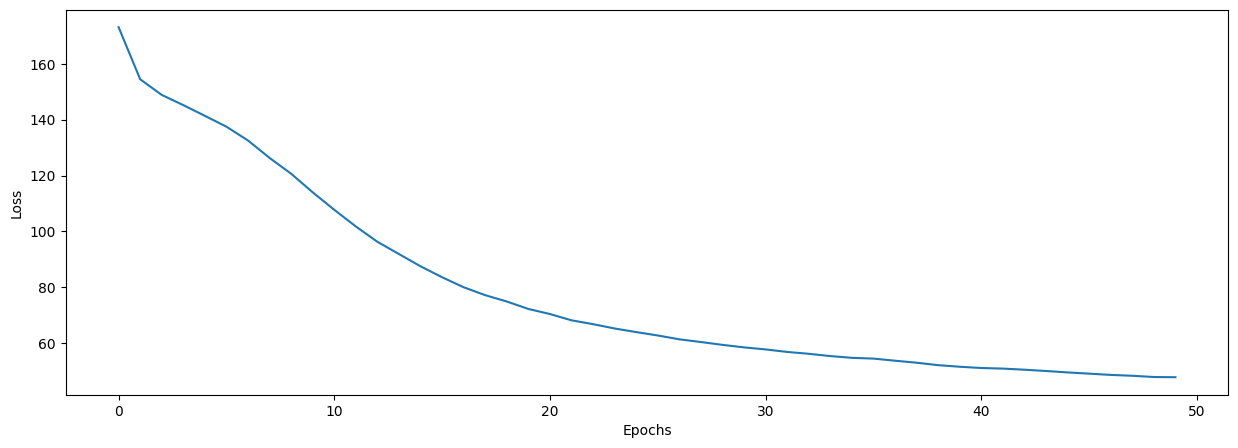

In [37]:
print(len(train_loss_avg))
print(train_loss_avg[-1])
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# LOAD MODEL IF AVALIABLE
Since training is a slow process we have already trained some

In [10]:
# Load model
inp = input()
inp = inp.split()[0].split(".")[0]
if(inp!=""):
    cnet.load_state_dict(torch.load("./data/pretrained/"+inp+".pth"))
else:
    print("Invalid file name")

To see for ourselves that the model is working lets take a sample of images from the validation dataset, compute the predicted colours, and display them alongside the originals

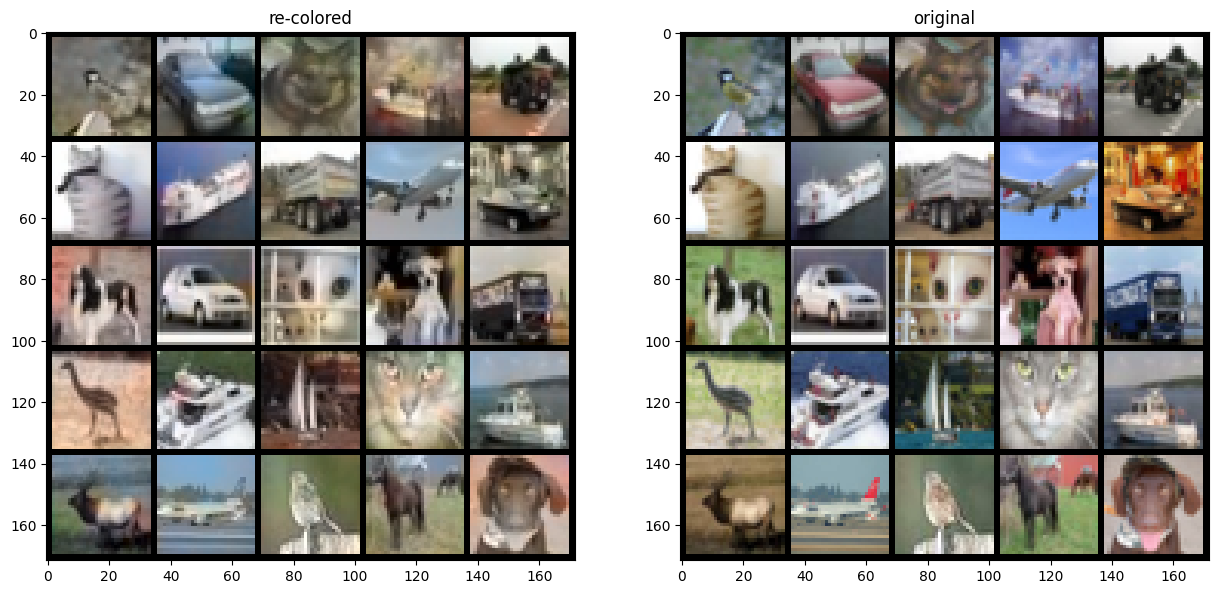

In [12]:
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(validation_data), 25, replace=False)
    lab_batch = torch.stack([validation_data[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch,_ = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()


We can see that although not perfect it manages to, more often than not, produce images with believable colours even if they might not match exactly with the original.

The code bellow is intended to run only if we wish to save a model.

In [ ]:
# Save model
inp = input()
inp = inp.split()[0].split(".")[0]
if(inp!=""):
    torch.save(cnet.state_dict(), "./data/pretrained/"+inp+".pth")
else:
    print("Invalid file name")


# Task 2
This task demands that we build an image classifier and test the impact of having it be trained from scratch with random weights and by having the model from the last task act as a pretask and feed feature information to the classifier. To do this we feed the colour image and first apply some convolutional layers with stride of 2 (similar to some of the ColorNet model) so that the layer size matches the feature data that we get from the ColorNet. This way we can concatenate the layers output and feed it to rest of classifier specific layers.
We will make the inclusion of the ColorNet feature data be optional to test its impact. 

In [21]:
# Define your SSL classification model
class SSLClassifier(nn.Module):
    def __init__(self, colorization_model=None):
        super(SSLClassifier, self).__init__()
        self.colorization_model = colorization_model
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        

        # Additional layers for classification on top of the colorization model
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1024, 128) if self.colorization_model is not None else nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        if(self.colorization_model is not None):
            _,features = self.colorization_model(x[:, 0:1, :, :])
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        if(self.colorization_model is not None):
            new_x = torch.cat((x,features),1)
            x =  self.layers(new_x)
        else: x = self.layers(x)
        return x

Once again we define some vaiables for training.
The loss function CrossEntropyLoss is used as it is suitable loss function for multi-class classification problems and we will be using the same optimizer as before.
First we will test the model without the pretask

In [22]:
# Create your SSL classifier model
num_classes = 10  # Number of classes in CIFAR-10
ssl_model = SSLClassifier()
ssl_model.to(device)
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation


In [23]:
summary(ssl_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
           Dropout-9            [-1, 128, 2, 2]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

The following function defines the training loop similar to before but this time comparing the output category with the label of the image.

In [24]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
        for lab_batch, y in tqdm(train_dataloader):
            y = y.to(device)
            lab_batch = lab_batch.to(device)

            # Compute prediction error
            pred = model(lab_batch)
            loss = loss_fn(pred, y)

            if is_train:
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Save training metrics
            total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

            probs = F.softmax(pred, dim=1)
            final_pred = torch.argmax(probs, dim=1)
            preds.extend(final_pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

And now to train it for some iterations and save the train and validation loss and accuracy values

In [25]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, ssl_model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, ssl_model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Train loss: 1.668 	 Train acc: 0.389


100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Val loss: 6.442 	 Val acc: 0.526

Epoch 2


100%|██████████| 98/98 [00:48<00:00,  2.02it/s]


Train loss: 1.322 	 Train acc: 0.520


100%|██████████| 98/98 [00:40<00:00,  2.43it/s]


Val loss: 5.726 	 Val acc: 0.584

Epoch 3


100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train loss: 1.182 	 Train acc: 0.580


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Val loss: 4.843 	 Val acc: 0.649

Epoch 4


100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Train loss: 1.081 	 Train acc: 0.610


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


Val loss: 4.576 	 Val acc: 0.668

Epoch 5


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Train loss: 1.002 	 Train acc: 0.643


100%|██████████| 98/98 [00:38<00:00,  2.57it/s]


Val loss: 4.250 	 Val acc: 0.692

Epoch 6


100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Train loss: 0.946 	 Train acc: 0.664


100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Val loss: 3.710 	 Val acc: 0.739

Epoch 7


100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Train loss: 0.890 	 Train acc: 0.684


100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Val loss: 3.537 	 Val acc: 0.747

Epoch 8


100%|██████████| 98/98 [00:55<00:00,  1.78it/s]


Train loss: 0.852 	 Train acc: 0.696


100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


Val loss: 3.374 	 Val acc: 0.758

Epoch 9


100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Train loss: 0.802 	 Train acc: 0.717


100%|██████████| 98/98 [00:35<00:00,  2.76it/s]


Val loss: 3.082 	 Val acc: 0.779

Epoch 10


100%|██████████| 98/98 [00:40<00:00,  2.39it/s]


Train loss: 0.765 	 Train acc: 0.730


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]

Val loss: 3.428 	 Val acc: 0.748
Finished


This helper function lets us plot the oforementioned loss and accuracy values

In [26]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

And here they are

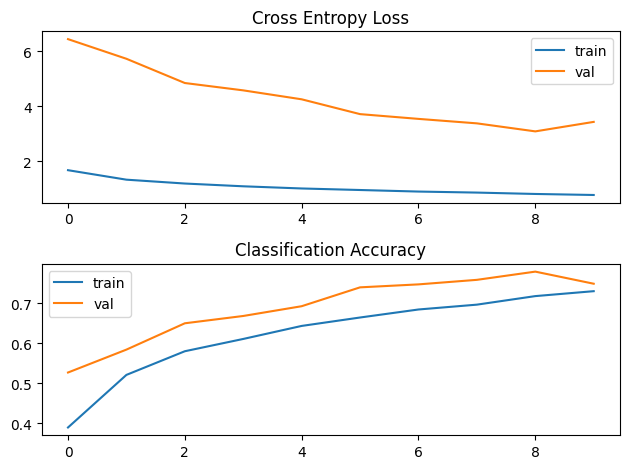

In [27]:
plotTrainingHistory(train_history, val_history)

Like we did for the previous taks let's take some images from the validation dataset and compare the the predicted and true labels for ilustration.

In [28]:
def showErrors(model, dataloader, num_examples=20):    
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, classes[y[0].item()], fontsize=14, color='green') # correct
      plt.text(-1, 8, classes[final_pred[0].item()], fontsize=14, color='red')  # predicted
      x,y,z = X[0].cpu()
      res = [ [0]*32 for i in range(32)]
      for i in range(32):
         for j in range(32):
            res[i][j] = [x[i,j],y[i,j],z[i,j]]
            res[i][j] = color.lab2rgb(res[i][j])
      plt.imshow(res)
    plt.show()

For each picture we have the true label in green and the prediction in red

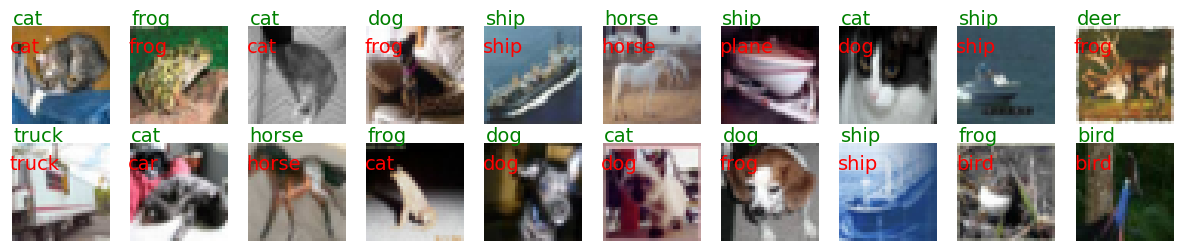

In [29]:
showErrors(ssl_model, validation_dataloader)

We will now do the same process but with the image recolouring pretask.

In [30]:
# Create your SSL classifier model
num_classes = 10  # Number of classes in CIFAR-10
ssl_model = SSLClassifier(cnet)
ssl_model.to(device)
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
summary(ssl_model,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
            Conv2d-9            [-1, 128, 4, 4]         147,584
      BatchNorm2d-10            [-1, 128, 4, 4]             256
           Conv2d-11            [-1, 128, 4, 4]         147,584
      BatchNorm2d-12            [-1, 128, 4, 4]             256
  ConvTranspose2d-13             [-1, 64, 8, 8]         131,136
      BatchNorm2d-14             [-1, 6

In [31]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, ssl_model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, ssl_model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


Train loss: 1.450 	 Train acc: 0.469


100%|██████████| 98/98 [00:35<00:00,  2.75it/s]


Val loss: 5.156 	 Val acc: 0.626

Epoch 2


100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Train loss: 1.037 	 Train acc: 0.627


100%|██████████| 98/98 [00:34<00:00,  2.86it/s]


Val loss: 3.916 	 Val acc: 0.721

Epoch 3


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


Train loss: 0.850 	 Train acc: 0.698


100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


Val loss: 3.635 	 Val acc: 0.741

Epoch 4


100%|██████████| 98/98 [00:55<00:00,  1.78it/s]


Train loss: 0.693 	 Train acc: 0.754


100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Val loss: 2.883 	 Val acc: 0.787

Epoch 5


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Train loss: 0.562 	 Train acc: 0.799


100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


Val loss: 1.892 	 Val acc: 0.872

Epoch 6


100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Train loss: 0.445 	 Train acc: 0.843


100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Val loss: 2.673 	 Val acc: 0.808

Epoch 7


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]


Train loss: 0.358 	 Train acc: 0.873


100%|██████████| 98/98 [00:30<00:00,  3.19it/s]


Val loss: 1.108 	 Val acc: 0.922

Epoch 8


100%|██████████| 98/98 [00:33<00:00,  2.89it/s]


Train loss: 0.287 	 Train acc: 0.898


100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


Val loss: 1.435 	 Val acc: 0.897

Epoch 9


100%|██████████| 98/98 [00:34<00:00,  2.85it/s]


Train loss: 0.237 	 Train acc: 0.916


100%|██████████| 98/98 [00:30<00:00,  3.25it/s]


Val loss: 0.719 	 Val acc: 0.951

Epoch 10


100%|██████████| 98/98 [00:34<00:00,  2.81it/s]


Train loss: 0.194 	 Train acc: 0.932


100%|██████████| 98/98 [00:30<00:00,  3.24it/s]

Val loss: 0.647 	 Val acc: 0.955
Finished


Once again lets plot the loss and accuracy values of the training loop

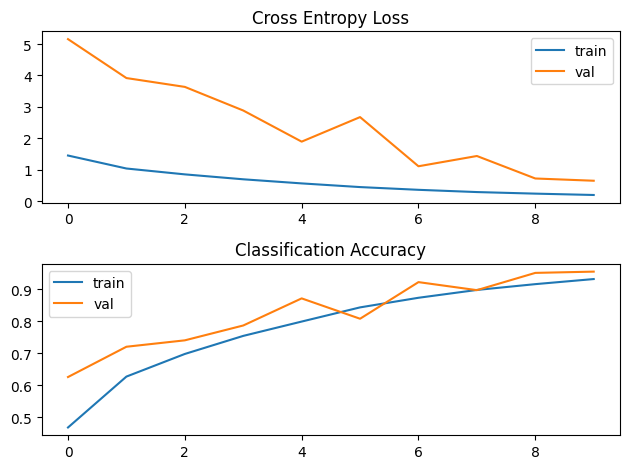

In [32]:
plotTrainingHistory(train_history, val_history)


And one more time see examples of the output

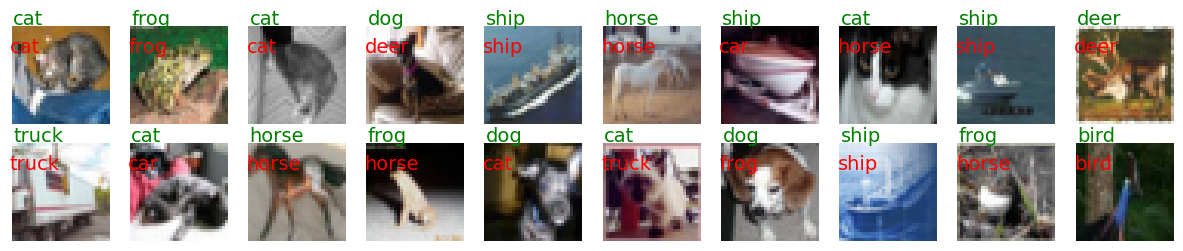

In [33]:
showErrors(ssl_model, validation_dataloader)